In [21]:
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Lasso, LinearRegression
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from pycaret.regression import setup, compare_models
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [9]:
df = pd.read_csv('../data/newborn_train.csv')

In [10]:
df.head()

,mother_body_mass_index,mother_marital_status,mother_delivery_weight,mother_race,mother_height,mother_weight_gain,father_age,father_education,cigarettes_before_pregnancy,prenatal_care_month,number_prenatal_visits,previous_cesarean,newborn_gender,newborn_weight
0,30.8,2.0,220.0,1,65.0,35.0,29.0,6,0.0,2,10.0,N,F,3045
1,45.8,NaN,293.0,1,64.0,26.0,37.0,4,0.0,3,10.0,N,F,3061
2,NaN,1.0,NaN,1,66.0,NaN,33.0,6,0.0,3,NaN,N,F,3827
3,24.3,1.0,157.0,1,NaN,20.0,27.0,6,0.0,3,9.0,N,M,3997
4,24.1,1.0,187.0,1,65.0,42.0,29.0,8,0.0,2,12.0,N,F,3240


In [11]:
df.previous_cesarean = df.previous_cesarean.map({'N': 0, 'Y': 1})
df.newborn_gender = df.newborn_gender.map({'F': 0, 'M': 1})

In [12]:
X, X_test, y, y_test = train_test_split(df.drop(columns='newborn_weight'), df.newborn_weight, test_size=0.1)

In [13]:
clf = setup(df, target='newborn_weight', use_gpu=True, n_jobs=-1, fold=5)

,Description,Value
0,Session id,1352
1,Target,newborn_weight
2,Target type,Regression
3,Original data shape,"(2398116, 14)"
4,Transformed data shape,"(2398116, 14)"
5,Transformed train set shape,"(1678681, 14)"
6,Transformed test set shape,"(719435, 14)"
7,Numeric features,13
8,Rows with missing values,45.1%
9,Preprocess,True


In [14]:
best = compare_models(include=['lr', 'lasso', 'ridge', 'en', 'knn', 'dt', 'rf', 'ada', 'xgboost', 'dummy'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,402.9049,293005.0081,541.2991,0.1590,0.2123,0.1552,0.8920
rf,Random Forest Regressor,413.6692,304401.9691,551.7260,0.1263,0.2134,0.1569,46.6180
lr,Linear Regression,413.6904,316065.3470,562.1968,0.0928,0.2219,0.1630,0.9320
lasso,Lasso Regression,413.6837,316083.3045,562.2127,0.0928,0.2219,0.1630,1.0880
ridge,Ridge Regression,413.6904,316065.3471,562.1968,0.0928,0.2219,0.1630,0.2800
en,Elastic Net,415.8310,318672.0655,564.5104,0.0854,0.2226,0.1638,0.8880
ada,AdaBoost Regressor,430.3553,323942.3802,569.1576,0.0702,0.2182,0.1610,33.0760
dummy,Dummy Regressor,435.7670,348413.3991,590.2653,-0.0000,0.2306,0.1720,0.2660
knn,K Neighbors Regressor,450.5729,357362.2183,597.7977,-0.0257,0.2281,0.1715,11.1080
dt,Decision Tree Regressor,597.7616,624306.2932,790.1301,-0.7919,0.3081,0.2145,10.1080


In [17]:
lasso = compare_models(include=['lasso'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,413.6837,316083.3045,562.2127,0.0928,0.2219,0.1630,0.2640


In [18]:
rf = compare_models(include=['rf'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,413.6692,304401.9691,551.7260,0.1263,0.2134,0.1569,45.9560


In [23]:
scaler = MinMaxScaler()
df_xgb = pd.DataFrame({
    'feature': best.feature_names_in_,
    'importance': scaler.fit_transform(best.feature_importances_.reshape(-1, 1)).ravel(),
    'model_type': 'XGB'
})
scaler = MinMaxScaler()
df_lasso = pd.DataFrame({
    'feature': best.feature_names_in_,
    'importance': scaler.fit_transform(lasso.coef_.reshape(-1, 1)).ravel(),
    'model_type': 'Lasso'
})
scaler = MinMaxScaler()
df_rf = pd.DataFrame({
    'feature': rf.feature_names_in_,
    'importance': scaler.fit_transform(rf.feature_importances_.reshape(-1, 1)).ravel(),
    'model_type': 'Random Forest'
})

Text(0, 0.5, 'Feature')

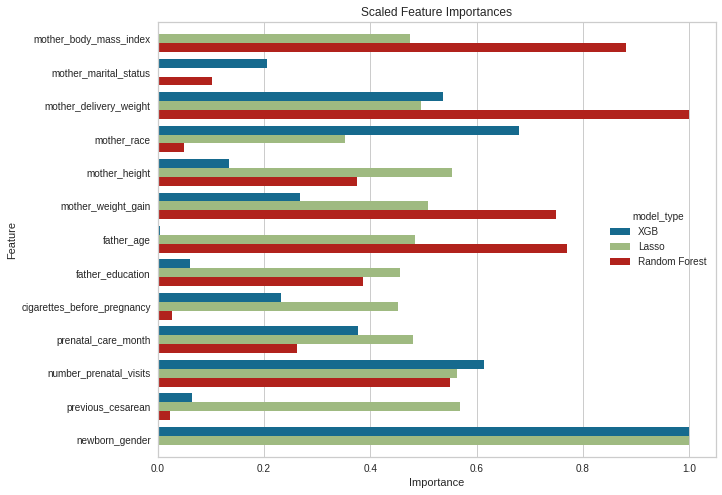

In [28]:
df = pd.concat([df_xgb, df_lasso, df_rf])

# Plot the data
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', hue='model_type', data=df, orient='h')
plt.title('Scaled Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')

Text(0, 0.5, 'Feature')

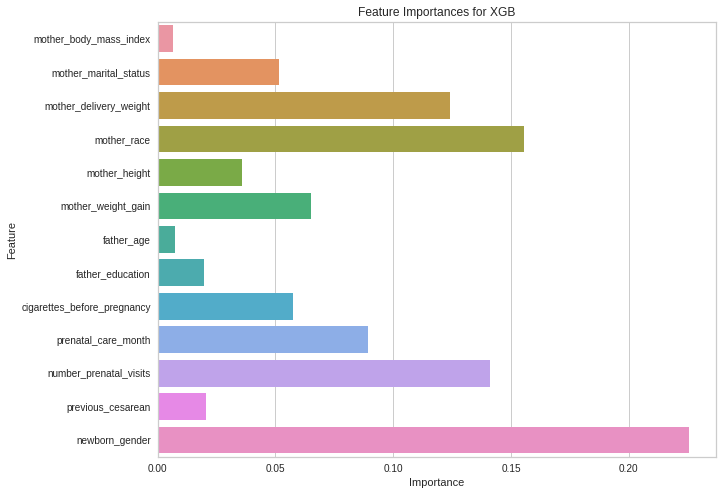

In [25]:
df_xgb_raw = pd.DataFrame({
    'feature': best.feature_names_in_,
    'importance': best.feature_importances_,
    'model_type': 'XGB'
})
# Plot the data
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=df_xgb_raw, orient='h')
plt.title('Feature Importances for XGB')
plt.xlabel('Importance')
plt.ylabel('Feature')

Text(0, 0.5, 'Feature')

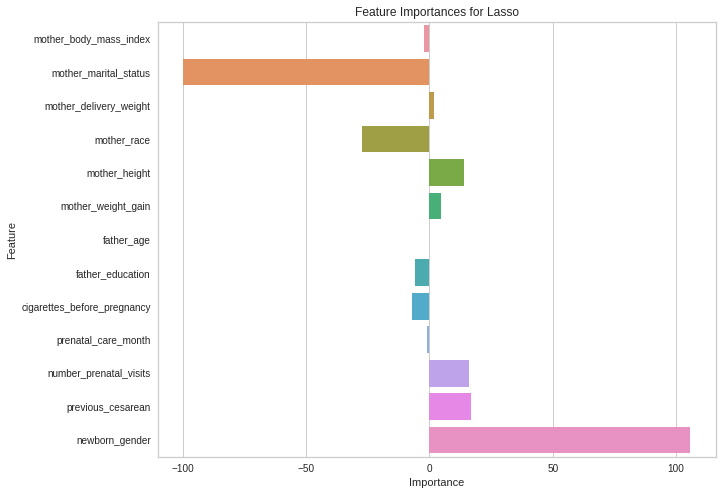

In [26]:
df_lasso_raw = pd.DataFrame({
    'feature': best.feature_names_in_,
    'importance': lasso.coef_,
    'model_type': 'Lasso'
})
# Plot the data
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=df_lasso_raw, orient='h')
plt.title('Feature Importances for Lasso')
plt.xlabel('Importance')
plt.ylabel('Feature')

Text(0, 0.5, 'Feature')

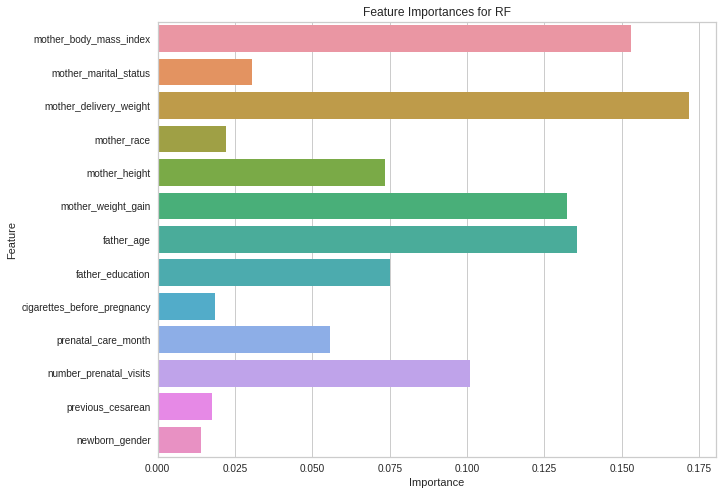

In [27]:
df_rf_raw = pd.DataFrame({
    'feature': rf.feature_names_in_,
    'importance': rf.feature_importances_,
    'model_type': 'Random Forest'
})
# Plot the data
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=df_rf_raw, orient='h')
plt.title('Feature Importances for RF')
plt.xlabel('Importance')
plt.ylabel('Feature')

When it comes to least important features shared by the models, we have decided to drop:
- mother marital status
- cigarettes between pregnancy
- previous cesarean

In [ ]:
X = X.drop(columns=['mother_marital_status', 'cigarettes_before_pregnancy', 'previous_cesarean'])

In [ ]:
model_lst = [Lasso, LinearRegression, xgb.XGBRegressor]
mape_dct_train = dict()
mape_dct_test = dict()
for model_base in model_lst:
    mape_dct_train[str(model_base)] = []
    mape_dct_test[str(model_base)] = []

Checking predictions on imputed datasets, with repeated k fold cv

In [ ]:
rkf = RepeatedKFold(random_state=420602)
i = 0
for train_index, test_index in rkf.split(X, y):
    print(f'split {i}')
    i += 1
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # imputation goes here
    scaler = RobustScaler()
    imputer = IterativeImputer()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    imputer.fit(X_train_scaled)
    X_train_imputed = imputer.transform(X_train_scaled)
    X_test_scaled = scaler.transform(X_test)
    X_test_imputed = imputer.transform(X_test_scaled)
    # models
    for model_base in model_lst:
        if 'xgb' in str(model_base):
            params_gpu = {"tree_method": "gpu_hist", "gpu_id": 0, "eval_metric": "mape"}
            model = model_base(**params_gpu)
        else:
            model = model_base()
        model.fit(X_train_imputed, y_train)
        pred_train = model.predict(X_test_imputed)
        pred_test = model.predict(X_train_imputed)
        mape_dct_test[str(model_base)].append(mean_absolute_percentage_error(y_test, pred_test))
        mape_dct_train[str(model_base)].append(mean_absolute_percentage_error(y_train, pred_train))
        print(f'finished model {str(model)} for this split')

split 0


scores

In [ ]:
for model_base in model_lst:
    print(f'{str(model_base)} avg score on train: {np.avg(mape_dct_train[str(model_base)])} and on test: {np.avg(mape_dct_test[str(model_base)])}')

So we focus on xgboost due to highest performance.
Additional random search for xgb:

In [ ]:
possible_params = {
    "n_estimators": [10, 25, 50, 100, 250],
    "eta": [0.1, 0.15, 0.2],
    "max_depth": [3, 5, 7],
    "colsample_bytree": [0.8, 0.9],
    "gamma": [0, 1, 3, 5],
    "eval_metric": ["mape"],
    "objective": ["reg:absoluteerror", "reg:squarederror"],
    "booster": ["gbtree"],
    "tree_method": ["gpu_hist"],
    "gpu_id": [0],
}

In [ ]:
xgbr = xgb.XGBRegressor()
clf = RandomizedSearchCV(xgbr, possible_params, n_iter=25, n_jobs=-1, verbose=1)

In [ ]:
search = clf.fit(X, y)

In [ ]:
search.best_params

In [ ]:
cv_res = pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')

In [ ]:
cv_res

Additionally checking best models scores on oos test

In [ ]:
params1 = cv_res.iloc[0, -1]
params2 = cv_res.iloc[1, -1]
params3 = cv_res.iloc[2, -1]
xgb_1 = xgb.XGBRegressor(**params1)
xgb_2 = xgb.XGBRegressor(**params2)
xgb_3 = xgb.XGBRegressor(**params3)

In [ ]:
print(f'params 1 score on oos test: {mean_absolute_percentage_error(xgb_1.predict(X_test), y_test)}')
print(f'params 2 score on oos test: {mean_absolute_percentage_error(xgb_2.predict(X_test), y_test)}')
print(f'params 3 score on oos test: {mean_absolute_percentage_error(xgb_3.predict(X_test), y_test)}')

In [ ]:
params1

In [ ]:
params2

In [ ]:
params3